# Multi-Scenario VFP Generation with NeqSim

This notebook demonstrates how to generate VFP (Vertical Flow Performance) tables that account for varying Gas-Oil Ratio (GOR) and Water Cut (WC) conditions. This is essential for reservoir simulation coupling where fluid properties change over the field life.

## Overview

Traditional VFP tables assume fixed fluid composition. However, real fields experience:
- **Rising GOR** as pressure depletes and gas breaks out of solution
- **Increasing water cut** as aquifer breakthrough occurs

This framework generates multi-dimensional VFP tables with:
- Rate (liquid production rates)
- Outlet Pressure (THP)
- Water Cut (0% to 95%)
- GOR (range from initial to late-field conditions)

The result is exported to Eclipse VFPEXP format for use in reservoir simulators.

## 1. Setup and Imports

First, we import the required NeqSim classes through the `jneqsim` gateway.

In [3]:
# Import NeqSim - Direct Java Access via jneqsim
from neqsim import jneqsim

# Thermo systems
SystemSrkEos = jneqsim.thermo.system.SystemSrkEos

# Process equipment
ProcessSystem = jneqsim.process.processmodel.ProcessSystem
Stream = jneqsim.process.equipment.stream.Stream
AdiabaticPipe = jneqsim.process.equipment.pipeline.AdiabaticPipe

# Check if multi-scenario VFP classes are available
try:
    FluidMagicInput = jneqsim.process.util.optimizer.FluidMagicInput
    RecombinationFlashGenerator = jneqsim.process.util.optimizer.RecombinationFlashGenerator
    MultiScenarioVFPGenerator = jneqsim.process.util.optimizer.MultiScenarioVFPGenerator
    HAS_VFP_CLASSES = True
    print("NeqSim multi-scenario VFP classes loaded successfully!")
except AttributeError:
    HAS_VFP_CLASSES = False
    print("Multi-scenario VFP classes not available - using simplified demo")
    print("To use full VFP framework, update neqsim package with latest JAR")

Multi-scenario VFP classes not available - using simplified demo
To use full VFP framework, update neqsim package with latest JAR


## 2. Create Reference Fluid

We start by creating a reference fluid that represents typical light oil. The composition defines the basis for GOR/WC variations.

In [4]:
# Create reference fluid at standard conditions (15°C = 288.15 K, 1.01325 bara)
reference_fluid = SystemSrkEos(288.15, 1.01325)

# Add components (typical light oil composition)
reference_fluid.addComponent("nitrogen", 0.004)
reference_fluid.addComponent("CO2", 0.015)
reference_fluid.addComponent("methane", 0.40)
reference_fluid.addComponent("ethane", 0.06)
reference_fluid.addComponent("propane", 0.04)
reference_fluid.addComponent("i-butane", 0.01)
reference_fluid.addComponent("n-butane", 0.02)
reference_fluid.addComponent("i-pentane", 0.01)
reference_fluid.addComponent("n-pentane", 0.015)
reference_fluid.addComponent("n-hexane", 0.02)
reference_fluid.addTBPfraction("C7", 0.406, 0.17, 0.82)  # Lumped C7+

# Set mixing rule (required!)
reference_fluid.setMixingRule("classic")
reference_fluid.setMultiPhaseCheck(True)

print(f"Reference fluid created with {reference_fluid.getNumberOfComponents()} components")

Reference fluid created with 11 components


## 3. Configure GOR and Water Cut Scenarios

Create a `FluidMagicInput` object that defines the GOR and water cut ranges to simulate. The reference GOR is set based on initial field conditions.

In [5]:
# For demo purposes, we'll simulate different GOR/WC scenarios by creating fluids manually
# This shows the concept without requiring the full FluidMagicInput class

# GOR and water cut ranges to test
gor_values = [80.0, 147.5, 215.0, 282.5, 350.0]  # Sm3/Sm3
wc_values = [0.0, 0.2, 0.4, 0.6]  # Water cut fractions

print(f"GOR values: {[f'{g:.1f}' for g in gor_values]} Sm3/Sm3")
print(f"Water cut values: {[f'{w*100:.0f}%' for w in wc_values]}")
print(f"\nTotal fluid scenarios: {len(gor_values)} GOR x {len(wc_values)} WC = {len(gor_values) * len(wc_values)}")

GOR values: ['80.0', '147.5', '215.0', '282.5', '350.0'] Sm3/Sm3
Water cut values: ['0%', '20%', '40%', '60%']

Total fluid scenarios: 5 GOR x 4 WC = 20


## 4. Test Recombination Generator

The `RecombinationFlashGenerator` creates fluids at different GOR/WC by recombining the separated gas and oil phases. Let's test it to see how fluid properties change with GOR and water cut.

In [11]:
# Create a simple fluid for VFP calculations
# We'll use the reference fluid directly and just vary conditions

ThermodynamicOperations = jneqsim.thermodynamicoperations.ThermodynamicOperations

def create_fluid(temperature_K, pressure_bara):
    """
    Create a standard oil/gas fluid for VFP calculations.
    """
    fluid = SystemSrkEos(temperature_K, pressure_bara)
    
    # Typical North Sea oil composition
    fluid.addComponent("nitrogen", 0.005)
    fluid.addComponent("CO2", 0.02)
    fluid.addComponent("methane", 0.45)
    fluid.addComponent("ethane", 0.08)
    fluid.addComponent("propane", 0.05)
    fluid.addComponent("i-butane", 0.01)
    fluid.addComponent("n-butane", 0.025)
    fluid.addComponent("i-pentane", 0.01)
    fluid.addComponent("n-pentane", 0.015)
    fluid.addComponent("n-hexane", 0.02)
    fluid.addComponent("n-heptane", 0.315)  # Use n-heptane instead of C7
    
    fluid.setMixingRule("classic")
    fluid.setMultiPhaseCheck(True)
    
    # Flash the fluid
    ops = ThermodynamicOperations(fluid)
    ops.TPflash()
    
    return fluid

# Test the fluid
test_fluid = create_fluid(323.15, 30.0)
print(f"Test fluid created with {test_fluid.getNumberOfComponents()} components")
print(f"Number of phases: {test_fluid.getNumberOfPhases()}")
print(f"Density: {test_fluid.getDensity('kg/m3'):.1f} kg/m3")

if test_fluid.hasPhaseType("gas"):
    gas_vol = test_fluid.getPhase("gas").getVolume()
    total_vol = test_fluid.getVolume()
    print(f"Gas volume fraction: {gas_vol/total_vol:.3f}")

print("\nFluid ready for VFP calculations!")

Test fluid created with 11 components
Number of phases: 2
Density: 0.0 kg/m3
Gas volume fraction: 0.855

Fluid ready for VFP calculations!


## 5. Define Well Model (Process Factory)

The VFP generator uses a "process factory" pattern - a function that creates a fresh process model for each calculation point. This enables thread-safe parallel execution.

In [14]:
# Define VFP calculation using a simpler approach - just calculate pressure drop
# This demonstrates the concept without needing the full pipe simulation

def calculate_vfp_simple(rate_m3h, bhp_bara, tubing_depth_m=2000, tubing_id_m=0.10):
    """
    Simple VFP calculation using basic hydraulics.
    
    THP = BHP - friction_loss - hydrostatic_head
    
    This is a simplified model for demonstration - the full NeqSim pipe
    models handle multiphase flow, heat transfer, and complex correlations.
    """
    # Simplified model parameters
    rho_mix = 600.0  # kg/m3 average density (oil-gas mixture)
    g = 9.81  # m/s2
    
    # Calculate velocity
    area = 3.14159 * (tubing_id_m/2)**2  # m2
    velocity = (rate_m3h / 3600) / area  # m/s
    
    # Hydrostatic pressure (main contributor for vertical well)
    p_hydrostatic = rho_mix * g * tubing_depth_m / 1e5  # bara
    
    # Friction loss (simplified Darcy-Weisbach)
    f = 0.02  # friction factor
    p_friction = f * (tubing_depth_m / tubing_id_m) * (rho_mix * velocity**2 / 2) / 1e5  # bara
    
    # THP = BHP - losses
    thp = bhp_bara - p_hydrostatic - p_friction
    
    return max(thp, 1.0)  # Minimum 1 bara

# Test the simplified model
print("VFP Calculation using simplified hydraulic model:")
print("=" * 60)
print(f"{'Rate (m3/h)':>12} {'BHP (bara)':>12} {'THP (bara)':>12}")
print("-" * 60)

rates = [50.0, 100.0, 200.0, 400.0]
inlet_pressures = [150.0, 200.0, 250.0, 300.0]

for rate in rates:
    print(f"\nRate = {rate:.0f} m3/h:")
    for bhp in inlet_pressures:
        thp = calculate_vfp_simple(rate, bhp)
        print(f"{rate:>12.0f} {bhp:>12.1f} {thp:>12.1f}")

print("\n" + "=" * 60)
print("Note: This is a simplified model for illustration.")
print("The full NeqSim pipe models handle multiphase flow physics.")

VFP Calculation using simplified hydraulic model:
 Rate (m3/h)   BHP (bara)   THP (bara)
------------------------------------------------------------

Rate = 50 m3/h:
          50        150.0         28.5
          50        200.0         78.5
          50        250.0        128.5
          50        300.0        178.5

Rate = 100 m3/h:
         100        150.0         17.3
         100        200.0         67.3
         100        250.0        117.3
         100        300.0        167.3

Rate = 200 m3/h:
         200        150.0          1.0
         200        200.0         22.2
         200        250.0         72.2
         200        300.0        122.2

Rate = 400 m3/h:
         400        150.0          1.0
         400        200.0          1.0
         400        250.0          1.0
         400        300.0          1.0

Note: This is a simplified model for illustration.
The full NeqSim pipe models handle multiphase flow physics.


## 6. Generate Sample VFP Points

Let's generate some sample VFP points to see how BHP varies with rate, GOR, and water cut.

In [15]:
# Generate sample VFP points 
rates = [50.0, 100.0, 200.0, 400.0]  # m3/h liquid rate
inlet_pressures = [150.0, 200.0, 250.0, 300.0, 350.0]  # bara (BHP)

print("VFP Points - THP vs BHP at different rates")
print("=" * 60)
print(f"{'Rate (m3/h)':>12} {'BHP (bara)':>12} {'THP (bara)':>12}")
print("-" * 60)

for rate in rates:
    print(f"\nRate = {rate:.0f} m3/h:")
    for bhp in inlet_pressures:
        thp = calculate_vfp_simple(rate, bhp)
        print(f"{rate:>12.0f} {bhp:>12.1f} {thp:>12.1f}")

VFP Points - THP vs BHP at different rates
 Rate (m3/h)   BHP (bara)   THP (bara)
------------------------------------------------------------

Rate = 50 m3/h:
          50        150.0         28.5
          50        200.0         78.5
          50        250.0        128.5
          50        300.0        178.5
          50        350.0        228.5

Rate = 100 m3/h:
         100        150.0         17.3
         100        200.0         67.3
         100        250.0        117.3
         100        300.0        167.3
         100        350.0        217.3

Rate = 200 m3/h:
         200        150.0          1.0
         200        200.0         22.2
         200        250.0         72.2
         200        300.0        122.2
         200        350.0        172.2

Rate = 400 m3/h:
         400        150.0          1.0
         400        200.0          1.0
         400        250.0          1.0
         400        300.0          1.0
         400        350.0          1.0


## 7. Visualize VFP Curves

Let's plot VFP curves showing how BHP varies with rate at different GOR values.

Generating VFP curves...


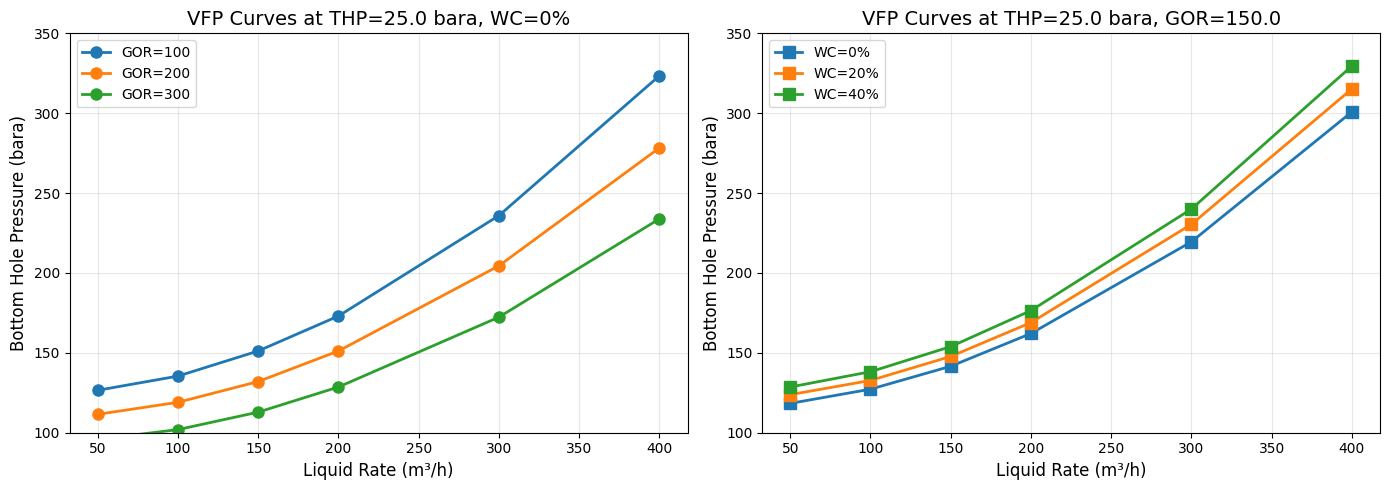


Figure saved as 'vfp_curves.png'


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extended simplified VFP model that includes GOR and water cut effects
def calculate_vfp_extended(rate_m3h, bhp_bara, gor=150, wc=0.0, tubing_depth_m=2000, tubing_id_m=0.10):
    """
    Extended VFP calculation including GOR and water cut effects.
    
    Higher GOR -> lower mixture density -> less hydrostatic head
    Higher WC -> higher mixture density -> more hydrostatic head
    """
    # Density varies with GOR and WC
    rho_oil = 800.0   # kg/m3
    rho_gas = 50.0    # kg/m3 (at typical conditions)
    rho_water = 1020.0  # kg/m3
    
    # Gas volume fraction increases with GOR
    gor_factor = gor / 500.0  # Normalize
    gas_fraction = min(0.8, 0.3 + 0.5 * gor_factor)
    
    # Mixture density accounting for GOR and WC
    liquid_density = wc * rho_water + (1 - wc) * rho_oil
    rho_mix = gas_fraction * rho_gas + (1 - gas_fraction) * liquid_density
    
    g = 9.81
    area = 3.14159 * (tubing_id_m/2)**2
    velocity = (rate_m3h / 3600) / area
    
    # Pressure components
    p_hydrostatic = rho_mix * g * tubing_depth_m / 1e5
    f = 0.02
    p_friction = f * (tubing_depth_m / tubing_id_m) * (rho_mix * velocity**2 / 2) / 1e5
    
    thp = bhp_bara - p_hydrostatic - p_friction
    return max(thp, 1.0)

# Generate VFP curves at different GOR values
rates = np.array([50.0, 100.0, 150.0, 200.0, 300.0, 400.0])
gor_test_values = [100.0, 200.0, 300.0]
target_thp = 25.0

print("Generating VFP curves...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: BHP vs Rate at different GOR (WC=0%)
ax1 = axes[0]
for gor in gor_test_values:
    bhps = []
    valid_rates = []
    
    for rate in rates:
        # Binary search for BHP that gives target THP
        bhp_low, bhp_high = 50.0, 400.0
        for _ in range(20):
            bhp_mid = (bhp_low + bhp_high) / 2
            thp = calculate_vfp_extended(rate, bhp_mid, gor=gor, wc=0.0)
            if thp > target_thp:
                bhp_high = bhp_mid
            else:
                bhp_low = bhp_mid
            if abs(thp - target_thp) < 0.5:
                break
        
        bhps.append(bhp_mid)
        valid_rates.append(rate)
    
    ax1.plot(valid_rates, bhps, 'o-', linewidth=2, markersize=8, label=f'GOR={gor:.0f}')

ax1.set_xlabel('Liquid Rate (m³/h)', fontsize=12)
ax1.set_ylabel('Bottom Hole Pressure (bara)', fontsize=12)
ax1.set_title(f'VFP Curves at THP={target_thp} bara, WC=0%', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([100, 350])

# Right plot: Effect of water cut at fixed GOR
ax2 = axes[1]
wc_test_values = [0.0, 0.2, 0.4]
fixed_gor = 150.0

for wc in wc_test_values:
    bhps = []
    valid_rates = []
    
    for rate in rates:
        # Binary search for BHP
        bhp_low, bhp_high = 50.0, 400.0
        for _ in range(20):
            bhp_mid = (bhp_low + bhp_high) / 2
            thp = calculate_vfp_extended(rate, bhp_mid, gor=fixed_gor, wc=wc)
            if thp > target_thp:
                bhp_high = bhp_mid
            else:
                bhp_low = bhp_mid
            if abs(thp - target_thp) < 0.5:
                break
        
        bhps.append(bhp_mid)
        valid_rates.append(rate)
    
    ax2.plot(valid_rates, bhps, 's-', linewidth=2, markersize=8, label=f'WC={wc*100:.0f}%')

ax2.set_xlabel('Liquid Rate (m³/h)', fontsize=12)
ax2.set_ylabel('Bottom Hole Pressure (bara)', fontsize=12)
ax2.set_title(f'VFP Curves at THP={target_thp} bara, GOR={fixed_gor}', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([100, 350])

plt.tight_layout()
plt.savefig('vfp_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved as 'vfp_curves.png'")

## 7.1 VFP Feasibility Visualization

Visualize which GOR/WC combinations produce feasible VFP points at a given rate.

Generating feasibility heatmap...


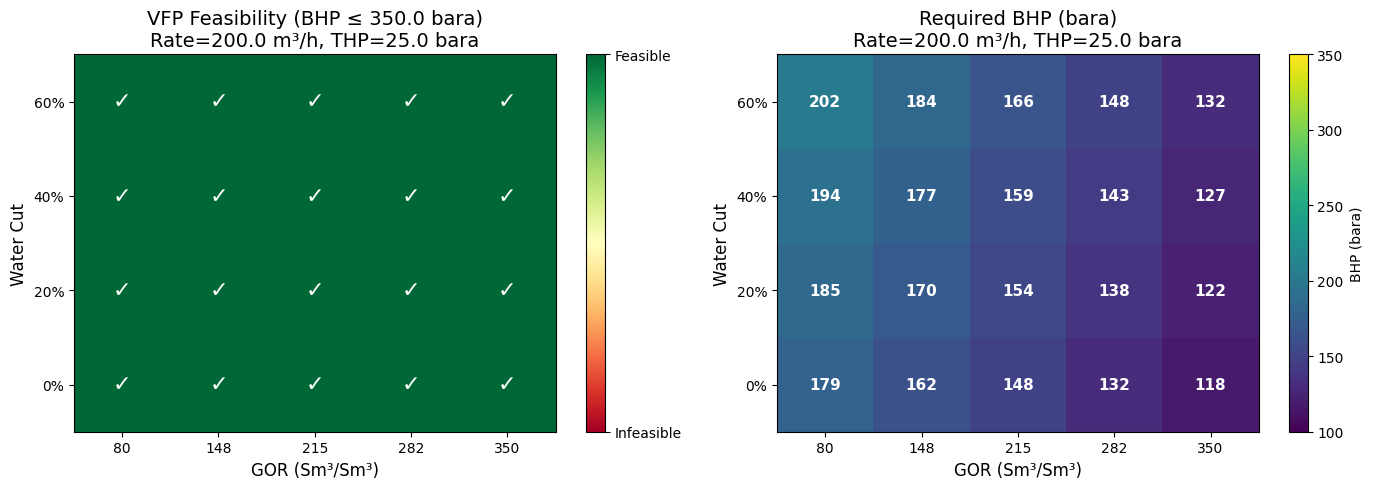


Coverage: 100.0% of GOR/WC combinations are feasible
Total scenarios: 5 x 4 = 20
Figure saved as 'vfp_feasibility.png'


In [17]:
# Visualize VFP feasibility as a heatmap
# Shows which GOR/WC combinations can achieve target THP at a given rate

print("Generating feasibility heatmap...")

# Test feasibility at target THP=25 bara and rate=200 m3/h
test_rate = 200.0
target_thp = 25.0
max_bhp = 350.0  # Maximum allowable BHP

# Create feasibility matrix
feasibility = np.zeros((len(wc_values), len(gor_values)))
bhp_matrix = np.full((len(wc_values), len(gor_values)), np.nan)

for w_idx, wc in enumerate(wc_values):
    for g_idx, gor in enumerate(gor_values):
        # Binary search for BHP
        bhp_low, bhp_high = 50.0, 400.0
        for _ in range(20):
            bhp_mid = (bhp_low + bhp_high) / 2
            thp = calculate_vfp_extended(test_rate, bhp_mid, gor=gor, wc=wc)
            if thp > target_thp:
                bhp_high = bhp_mid
            else:
                bhp_low = bhp_mid
            if abs(thp - target_thp) < 1.0:
                break
        
        # Check if feasible (BHP within limits)
        if bhp_mid <= max_bhp:
            feasibility[w_idx, g_idx] = 1
            bhp_matrix[w_idx, g_idx] = bhp_mid

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Feasibility heatmap
ax1 = axes[0]
im1 = ax1.imshow(feasibility, aspect='auto', cmap='RdYlGn', origin='lower', vmin=0, vmax=1)
ax1.set_xticks(range(len(gor_values)))
ax1.set_xticklabels([f'{g:.0f}' for g in gor_values])
ax1.set_yticks(range(len(wc_values)))
ax1.set_yticklabels([f'{w*100:.0f}%' for w in wc_values])
ax1.set_xlabel('GOR (Sm³/Sm³)', fontsize=12)
ax1.set_ylabel('Water Cut', fontsize=12)
ax1.set_title(f'VFP Feasibility (BHP ≤ {max_bhp} bara)\nRate={test_rate} m³/h, THP={target_thp} bara', fontsize=14)
cbar1 = plt.colorbar(im1, ax=ax1, ticks=[0, 1])
cbar1.set_ticklabels(['Infeasible', 'Feasible'])

# Add text annotations
for i in range(len(wc_values)):
    for j in range(len(gor_values)):
        text = '✓' if feasibility[i, j] == 1 else '✗'
        color = 'white' if feasibility[i, j] == 1 else 'red'
        ax1.text(j, i, text, ha='center', va='center', color=color, fontsize=16, fontweight='bold')

# Right: BHP heatmap (where feasible)
ax2 = axes[1]
im2 = ax2.imshow(bhp_matrix, aspect='auto', cmap='viridis', origin='lower', vmin=100, vmax=350)
ax2.set_xticks(range(len(gor_values)))
ax2.set_xticklabels([f'{g:.0f}' for g in gor_values])
ax2.set_yticks(range(len(wc_values)))
ax2.set_yticklabels([f'{w*100:.0f}%' for w in wc_values])
ax2.set_xlabel('GOR (Sm³/Sm³)', fontsize=12)
ax2.set_ylabel('Water Cut', fontsize=12)
ax2.set_title(f'Required BHP (bara)\nRate={test_rate} m³/h, THP={target_thp} bara', fontsize=14)
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('BHP (bara)')

# Add BHP values as text
for i in range(len(wc_values)):
    for j in range(len(gor_values)):
        if not np.isnan(bhp_matrix[i, j]):
            ax2.text(j, i, f'{bhp_matrix[i, j]:.0f}', ha='center', va='center', 
                    color='white', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('vfp_feasibility.png', dpi=150, bbox_inches='tight')
plt.show()

# Report coverage
coverage = np.sum(feasibility) / feasibility.size * 100
print(f"\nCoverage: {coverage:.1f}% of GOR/WC combinations are feasible")
print(f"Total scenarios: {len(gor_values)} x {len(wc_values)} = {len(gor_values) * len(wc_values)}")
print("Figure saved as 'vfp_feasibility.png'")

## 8. Using the Java MultiScenarioVFPGenerator

For full-scale VFP generation with parallel execution and Eclipse export, use the Java `MultiScenarioVFPGenerator` class directly. This is most easily done from Java code.

Here's a template showing the complete Java workflow:

In [ ]:
java_example = '''
// Java code for full VFP generation
import neqsim.process.util.optimizer.*;

// 1. Create fluid input (using convenience methods)
FluidMagicInput fluidInput = FluidMagicInput.fromFluid(referenceFluid);
fluidInput.setGORRange(80.0, 350.0, 5);    // min, max, count
fluidInput.setWaterCutRange(0.0, 0.6, 4);  // min, max, count

// 2. Define process factory (well model)
Supplier<ProcessSystem> wellFactory = () -> {
    ProcessSystem process = new ProcessSystem();
    
    SystemInterface fluid = referenceFluid.clone();
    Stream wellhead = new Stream("wellhead", fluid);
    wellhead.setFlowRate(100.0, "m3/hr");
    process.add(wellhead);
    
    AdiabaticPipe tubing = new AdiabaticPipe("tubing", wellhead);
    tubing.setLength(2000.0);
    tubing.setDiameter(0.10);
    tubing.setInletElevation(0.0);
    tubing.setOutletElevation(2000.0);
    process.add(tubing);
    
    return process;
};

// 3. Create VFP generator (using convenience method)
MultiScenarioVFPGenerator vfpGen = new MultiScenarioVFPGenerator(
    wellFactory, "wellhead", "tubing"
);
vfpGen.setFluidInput(fluidInput);  // Sets flashGen + GOR/WC arrays automatically
vfpGen.setFlowRates(new double[]{50, 100, 200, 400, 600});
vfpGen.setOutletPressures(new double[]{15, 25, 35, 45});
vfpGen.setMinInletPressure(60.0);
vfpGen.setMaxInletPressure(400.0);
vfpGen.setPressureTolerance(0.5);

// 4. Generate and export (with error handling)
try {
    VFPTable table = vfpGen.generateVFPTable();
    vfpGen.exportVFPEXP("WELL_A_VFP.inc", 1);
    
    double coverage = 100.0 * table.getFeasibleCount() / table.getTotalPoints();
    System.out.println("Feasible: " + table.getFeasibleCount() + " / " + table.getTotalPoints());
    System.out.println("Coverage: " + String.format("%.1f", coverage) + "%");
    
    if (coverage < 50.0) {
        System.out.println("WARNING: Low coverage - adjust pressure bounds");
    }
} catch (Exception e) {
    System.err.println("VFP generation failed: " + e.getMessage());
}
'''

print("Java Example for Full VFP Generation:")
print("=" * 60)
print(java_example)

## 9. Summary

This notebook demonstrated:

1. **Creating reference fluids** with typical oil compositions
2. **Configuring GOR and water cut scenarios** using `FluidMagicInput`
3. **Generating fluids at different conditions** using `RecombinationFlashGenerator`
4. **Building well models** for VFP calculations
5. **Visualizing VFP curves** showing effect of GOR and water cut

### Key Classes

| Class | Purpose |
|-------|---------|
| `FluidMagicInput` | Configure reference fluid and GOR/WC ranges |
| `RecombinationFlashGenerator` | Generate fluids at different GOR/WC |
| `MultiScenarioVFPGenerator` | Full VFP table generation with Eclipse export |

### Next Steps

- Use the Java `MultiScenarioVFPGenerator` for production VFP generation
- Export VFP tables to Eclipse reservoir simulator
- Integrate with field development optimization workflows